# Longitudinal and transverse cooling of relativistic electron beams in intense laser pulses

Original authors: Samuel R Yoffe, Yevgen Kravets, Adam Noble and Dino A Jaroszynski

Link to paper: https://iopscience.iop.org/article/10.1088/1367-2630/17/5/053025

Citation: Samuel R Yoffe et al 2015 New J. Phys. __17__ 053025

Notebook by: Óscar Amaro (2023)

__Note__: final average energy in figure 3 not exactly like in the paper...

In [4]:
# numpy
import numpy as np
np.random.seed(1)
from numpy.random import default_rng
rng = default_rng()
# import functions
from scipy.special import kv, iv, erf
from scipy.integrate import quad
from numpy import log, log10, sin, cos, exp, sqrt, pi
# root finding
from scipy.optimize import fsolve
from scipy import optimize
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm
# progress bar
from tqdm import trange

### Figure 1

Reduction of longitudinal beam cooling. (a): The ratio (23) of the longitudinal to the transverse phase space contraction in the semi-classical model.

$\beta_\bot = g ~ \hat{\beta}_\parallel, \beta_\parallel = \mathrm{eq 23}~\beta_\bot$, so $ \beta_\parallel/\hat{\beta}_\parallel = g ~\mathrm{eq 23} $

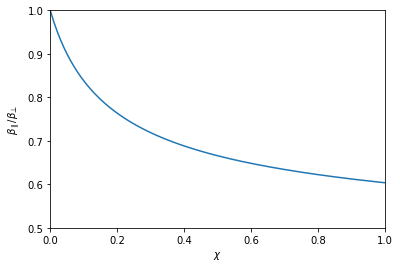

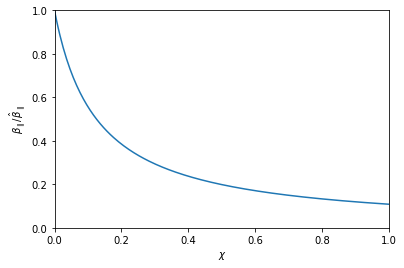

In [5]:
def g(chi): return (1+12*chi+31*chi**2+3.7*chi**3)**(-4/9)
def eq23(chi): return 1- 2/9 * chi * g(chi)**(9/4) * (12 + 62*chi + 11.1*chi**2)
chilst = np.linspace(1e-3,1,200)

plt.plot(chilst, eq23(chilst))
plt.xlim([0,1])
plt.ylim([0.5,1])
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\beta_\parallel/\beta_\bot$')
plt.show()

plt.plot(chilst, g(chilst)*eq23(chilst))
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\beta_\parallel/\hat{\beta}_\parallel$')
plt.show()

### §3. Numerical (re)construction of the particle distribution - figure 2

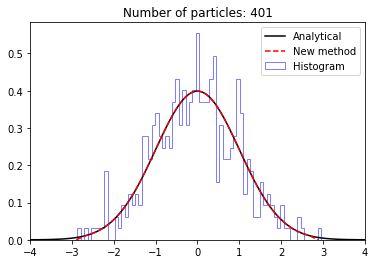

In [6]:
# distribution in coordinates
mu = 0
sigma = 1
Nc = 200
Np = int(2*Nc+1);
xdist = mu + sigma*rng.standard_normal(Np) #[\mu m]
binlst=np.linspace(-4,4,100)
dbin = binlst[1]-binlst[0]

def gaussfun(x,Np):
    return Np*1/sqrt(2*pi*sigma**2) * exp(-0.5*(x-mu)**2/sigma**2)

def new_method(mu, sigma, Nc, Np):

    p = np.zeros(Np)
    f = np.zeros(Np)
    dp = np.zeros(Np)
    p[Nc+0] = mu
    p[Nc+1] = mu + 1/gaussfun(mu,Np)
    p[Nc-1] = mu - 1/gaussfun(mu,Np)
    #
    for i in range(1,Nc+1):
        xi=1
        p[Nc+i] = p[Nc+i-2*xi] + 2*xi/gaussfun(p[Nc+i-xi],Np)
    for i in range(1,Nc+1):
        xi=-1
        p[Nc+i*xi] = p[Nc+i*xi-2*xi] + 2*xi/gaussfun(p[Nc+i*xi-xi],Np)
    # reconstruct distribution
    for i in range(1,Np-1):
        dp[i] = (p[i+1]-p[i-1])/2
        f[i] = 1/(dp[i])
    f_avg = np.sum(f * p)/np.sum(f)
    f_sig = np.sqrt( np.sum(f * p**2)/np.sum(f) )
    return p, f, f_avg, f_sig

p, f, _, _ = new_method(mu, sigma, Nc, Np)
plt.plot(binlst,gaussfun(binlst,Np)/Np,color='k',label='Analytical')
plt.plot(p,f/Np,'--',color='red',label='New method')
plt.hist(xdist,binlst,density=True,color='blue',label='Histogram',alpha=0.5, histtype='step')
plt.legend()
plt.xlim([-4,+4])
plt.title(r'Number of particles: {}'.format(Np))
plt.show()

In [7]:
Nclst = np.linspace(2, 1000, 22)
Nclst = Nclst.astype(int)
method_sigma = np.zeros(len(Nclst))
count = 0
for Nc in Nclst:
    _, _, _, sig = new_method(mu, sigma, Nc, int(2*Nc+1))
    method_sigma[count] = sig
    count += 1
Nclst2 = np.linspace(2, 1000, 200)
Nclst2 = Nclst2.astype(int)
method_sigma2 = np.zeros(len(Nclst2))
count = 0
for Nc in Nclst2:
    _, _, _, sig = new_method(mu, sigma, Nc, int(2*Nc+1))
    method_sigma2[count] = sig
    count += 1

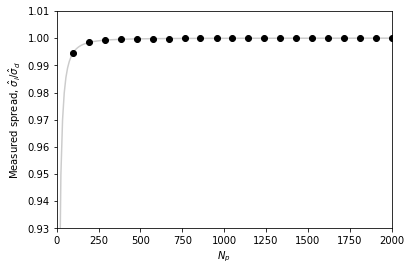

In [8]:
plt.plot(2*Nclst+1, method_sigma*sqrt(2), 'ko')
plt.plot(2*Nclst2+1, method_sigma2*sqrt(2), 'k-', alpha=0.2)
plt.xlim([0,2000])
plt.ylim([0.93,1.01])
plt.xlabel(r'$N_p$')
plt.ylabel(r'Measured spread, $\hat{\sigma}_i/\hat{\sigma}_d$')
plt.show()

### Figure 3

100%|██████████| 200/200 [02:16<00:00,  1.46it/s]


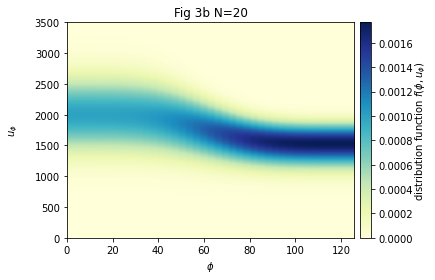

a0 = 21.50348808914498


In [13]:
lbd = 0.8 #[\mu m]
N = 20
L = 2*pi*N
tau = 6.4e-24 * 2*pi*3e8/(0.8e-6)
fluence = 9.248e3
mu = 2000
sigma = 2*200
a0 = sqrt( fluence/N )
def a(phi):
    return a0*sin(phi)*sin(pi*phi/L)**2
def scG(phi):
    """equation 28"""
    return quad(lambda phii: a(phii)**2,0,phi)[0]
def uphi0(phi, uphi):
    """equation 27"""
    return uphi/(1-tau*uphi*scG(phi))
def f0(uphi):
    """distribution at phi=0"""
    return 1/sqrt(2*pi*sigma**2) * exp(-0.5*(uphi-mu)**2/sigma**2)
def fphi(phi,uphi):
    """equation 31"""
    return f0(uphi/(1-tau*uphi*scG(phi)))/(1-tau*uphi*scG(phi))**2

philst = np.linspace(0,L,200)
uphilst = np.linspace(0,3500,200) # momentum
flst = np.zeros((len(philst),len(uphilst)))
for i in trange(len(philst)):
    for j in range(len(uphilst)):
        flst[i,j] = fphi(philst[i],uphilst[j])
        
# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
im0 = axes.imshow(flst.T, interpolation='bilinear', origin='lower', extent=[min(philst), max(philst), min(uphilst), max(uphilst)], cmap='YlGnBu') #np.max(flst)
#, 
axes.images.append(im0)
axes.set_xlabel(r'$\phi$')
axes.set_ylabel(r'$u_\phi$',labelpad=15)
#
cbar0 = fig.colorbar(im0, ax=axes,fraction=0.05, pad=0.02)
cbar0.set_label(r'distribution function $f(\phi,u_\phi)$',labelpad=1,y=0.5)
# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes.set_aspect(aspect=3/4/axesratio)
plt.title(r'Fig 3b N=20')
# final
plt.tight_layout()
plt.show()
print("a0 =",a0) # confirm with text

100%|██████████| 200/200 [00:38<00:00,  5.23it/s]


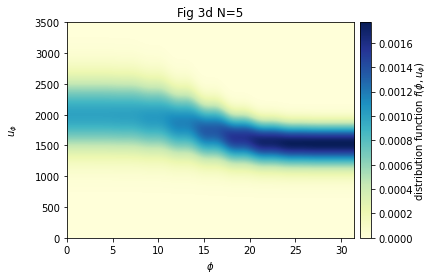

a0 = 43.00697617828996


In [14]:
lbd = 0.8 #[\mu m]
N = 5
L = 2*pi*N
tau = 6.4e-24 * 2*pi*3e8/(0.8e-6)
fluence = 9.248e3
mu = 2000
sigma = 2*200
a0 = sqrt( fluence/N )
def a(phi):
    return a0*sin(phi)*sin(pi*phi/L)**2
def scG(phi):
    """equation 28"""
    return quad(lambda phii: a(phii)**2,0,phi)[0]
def uphi0(phi, uphi):
    """equation 27"""
    return uphi/(1-tau*uphi*scG(phi))
def f0(uphi):
    """distribution at phi=0"""
    return 1/sqrt(2*pi*sigma**2) * exp(-0.5*(uphi-mu)**2/sigma**2)
def fphi(phi,uphi):
    """equation 31"""
    return f0(uphi/(1-tau*uphi*scG(phi)))/(1-tau*uphi*scG(phi))**2

philst = np.linspace(0,L,200)
uphilst = np.linspace(0,3500,200) # momentum
flst = np.zeros((len(philst),len(uphilst)))
for i in trange(len(philst)):
    for j in range(len(uphilst)):
        flst[i,j] = fphi(philst[i],uphilst[j])
        
# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
im0 = axes.imshow(flst.T, interpolation='bilinear', origin='lower', extent=[min(philst), max(philst), min(uphilst), max(uphilst)], cmap='YlGnBu') #np.max(flst)
#, 
axes.images.append(im0)
axes.set_xlabel(r'$\phi$')
axes.set_ylabel(r'$u_\phi$',labelpad=15)
#
cbar0 = fig.colorbar(im0, ax=axes,fraction=0.05, pad=0.02)
cbar0.set_label(r'distribution function $f(\phi,u_\phi)$',labelpad=1,y=0.5)
# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes.set_aspect(aspect=3/4/axesratio)
plt.title(r'Fig 3d N=5')
# final
plt.tight_layout()
plt.show()
print("a0 =",a0) # confirm with text